In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# ========== 1. 数据加载 ==========
def load_and_preprocess(file_path):
    """加载并预处理CMAPSS数据集"""
    df = pd.read_csv(file_path, sep=' ', header=None)
    df = df.dropna(axis=1, how='all')
    
    # 定义列名
    col_names = ['unit', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
        [f'sm_{i}' for i in range(1,22)]
    df.columns = col_names[:df.shape[1]]
    
    # 选择文献中的关键传感器
    selected_sensors = ['sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_9','sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
    
    # 确认数据集中传感器列的顺序并索引
    sensor_indices = [df.columns.get_loc(sensor) for sensor in selected_sensors]
    
    # 按发动机分组并归一化
    engines = []
    for engine_id in df['unit'].unique():
        engine = df[df['unit'] == engine_id].iloc[:, sensor_indices].values
        engines.append(MinMaxScaler().fit_transform(engine))
        
    return engines, col_names

In [4]:
# ========== 3. 构建VAE模型 ==========
class VAEDetector:
    def __init__(self, input_dim, latent_dim=2):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self._build_model()
    
    def _build_model(self):
        # 编码器
        inputs = Input(shape=(self.input_dim,))
        x = Dense(16, activation='relu')(inputs)
        x = Dense(8, activation='relu')(x)
        
        # 潜在空间分布参数
        z_mean = Dense(self.latent_dim)(x)
        z_log_var = Dense(self.latent_dim)(x)
        
        # 重参数化采样
        def sampling(args):
            z_mean, z_log_var = args
            epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
        z = Lambda(sampling)([z_mean, z_log_var])
        
        # 解码器
        decoder_input = Input(shape=(self.latent_dim,))
        d = Dense(8, activation='relu')(decoder_input)
        d = Dense(16, activation='relu')(d)
        outputs = Dense(self.input_dim, activation='tanh')(d)
        
        # 完整模型
        self.encoder = Model(inputs, z_mean)
        self.decoder = Model(decoder_input, outputs)
        self.vae = Model(inputs, self.decoder(z))
        
        # 自定义损失函数
        reconstruction_loss = K.mean(K.square(inputs - self.vae.output), axis=-1)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.vae.add_loss(K.mean(reconstruction_loss + kl_loss))
        self.vae.compile(optimizer='adam')

In [5]:
def find_anomaly_start(engine_data, smooth_window, detect_window_ratio, sigma):
    """
    参数：
        smooth_window: 平滑窗口大小 
        detect_window_ratio: 检测窗口占总周期的比例
    """
    # 计算原始重构误差
    reconstructions = detector.vae.predict(engine_data)
    mse = np.mean(np.square(engine_data - reconstructions), axis=1)
    
    # 滑动窗口平滑（使用卷积实现）
    window = np.ones(smooth_window)/smooth_window
    smoothed = np.convolve(mse, window, mode='valid')
    
    # 计算动态阈值（基于前20%的平滑数据）
    baseline_len = max(int(len(smoothed)*0.2), 5)  # 修正基线长度计算
    baseline = smoothed[:baseline_len]
    b_mean = np.mean(baseline)
    b_std = np.std(baseline)
    upper_thresh = b_mean + sigma * b_std
    lower_thresh = b_mean - sigma * b_std
    
    # 确定检测窗口大小（基于原始周期比例）
    detect_window = max(int(len(mse) * detect_window_ratio), 1)
    
    # 寻找所有超界点（基于平滑误差）
    # 生成对应关系数组
    exceed_points = np.where((smoothed > upper_thresh) | (smoothed < lower_thresh))[0]
    original_indices = exceed_points + (smooth_window - 1)
    
    # 使用迭代器同时遍历两个数组
    for idx, (smooth_idx, original_idx) in enumerate(zip(exceed_points, original_indices)):
        end_idx = smooth_idx + detect_window
        
        if end_idx >= len(smoothed):
            continue
            
        window_smoothed = smoothed[smooth_idx:end_idx]
        if np.all((window_smoothed > upper_thresh) | (window_smoothed < lower_thresh)):
            return original_idx  # 直接返回对应的原始索引
        
    return original_indices[-1] if len(original_indices) > 0 else len(mse)

In [6]:
def generate_HI(engine_data, column_names, smooth_window=15, detect_window_ratio=0.2, sigma=3.0):
    """生成健康指标曲线"""
    # 检测异常点
    anomaly_point = find_anomaly_start(engine_data, smooth_window, detect_window_ratio, sigma)
    total_cycles = len(engine_data)
    
    # 初始化HI
    HI = np.ones(total_cycles)
    
    # PCA融合退化特征
    if anomaly_point < total_cycles - 1:
        # 使用实际传感器列名动态选择传感器
        selected_sensor_names = ['sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
        selected_sensors = [i for i, sensor in enumerate(selected_sensor_names) if sensor in column_names]
        
        # 标准化处理
        scaler = StandardScaler()
        normal_data = scaler.fit_transform(engine_data[:anomaly_point, selected_sensors])
        degradation_data = scaler.transform(engine_data[anomaly_point:, selected_sensors])
        
        # PCA降维
        pca = PCA(n_components=1)
        pca.fit(normal_data)
        degradation_pca = pca.transform(degradation_data).flatten()
        
        # 方向校准
        if np.corrcoef(degradation_pca, np.arange(len(degradation_pca)))[0, 1] < 0:
            degradation_pca = -degradation_pca
            
        # 归一化和后处理
        degradation_hi = MinMaxScaler().fit_transform(degradation_pca.reshape(-1, 1)).flatten()
        degradation_hi = 1 - degradation_hi  # 翻转方向
        
        # 应用指数平滑
        alpha = 0.3
        for i in range(1, len(degradation_hi)):
            degradation_hi[i] = alpha * degradation_hi[i] + (1 - alpha) * degradation_hi[i - 1]
            
        HI[anomaly_point:] = degradation_hi
    
    return HI, anomaly_point

In [7]:
def visualize_results(engine_id, engines, column_names, detect_params):
    """综合可视化函数"""
    engine_data = engines[engine_id]
    HI, anomaly = generate_HI(engine_data, column_names, **detect_params)
    
    plt.figure(figsize=(15, 6))
    
    # 传感器数据面板
    plt.subplot(121)
    selected_sensor_names = ['sm_2', 'sm_3', 'sm_4']  # 选择展示的传感器名称
    selected_sensors = [column_names.index(sensor) for sensor in selected_sensor_names]
    for sensor_index in selected_sensors:
        sensor_name = column_names[sensor_index]
        plt.plot(engine_data[:, sensor_index], label=sensor_name, alpha=0.6)
    plt.axvline(anomaly, color='r', linestyle='--', linewidth=2)
    plt.xlabel('Operation Cycles')
    plt.ylabel('Normalized Value')
    plt.title(f'Engine {engine_id+1} Sensor Data\nTotal Cycles: {len(engine_data)}')
    plt.legend()
    
    # 健康指标面板
    plt.subplot(122)
    plt.plot(HI, color='darkorange', linewidth=2)
    plt.axvline(anomaly, color='r', linestyle='--', label=f'Anomaly at Cycle {anomaly}')
    plt.fill_between(range(len(HI)), HI, alpha=0.3, color='orange')
    plt.ylim(-0.1, 1.1)
    plt.xlabel('Operation Cycles')
    plt.ylabel('Health Indicator (HI)')
    plt.title('Health Degradation Profile')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
# 保存所有发动机的健康指标到一个文件
def save_all_hi_to_single_file(engines, column_names, detect_params, output_file="PWL_HI_train_FD001.csv"):
    """
    将所有发动机的健康指标保存到一个CSV文件中
    每行记录包含发动机编号、运行周期和对应的健康指标HI
    """
    # 创建一个空的DataFrame用于存储所有发动机的HI数据
    all_hi_data = []

    # 遍历所有发动机
    for engine_id, engine_data in enumerate(engines):
        HI, anomaly = generate_HI(engine_data, column_names, **detect_params)
        
        # 构建当前发动机的HI记录
        engine_hi_data = pd.DataFrame({
            'unit': [engine_id + 1] * len(HI),  # 发动机编号，从1开始
            'time': np.arange(1, len(HI) + 1),     # 运行周期
            'HI_smooth': HI,# 健康指标
            'anomaly_point':anomaly
        })
        
        # 添加到总数据中
        all_hi_data.append(engine_hi_data)

    # 合并所有发动机的数据
    all_hi_data = pd.concat(all_hi_data, ignore_index=True)

    # 保存到指定的CSV文件
    all_hi_data.to_csv(output_file, index=False)
    print(f"所有发动机HI数据已保存至：{output_file}")

In [9]:
# 参数配置
DETECT_PARAMS = {
        'smooth_window': 15,
        'detect_window_ratio': 0.1,
        'sigma': 3.0
    }
    
# 加载数据
engines, column_names = load_and_preprocess("data/train_FD001.txt")
print(f"成功加载 {len(engines)} 台发动机数据")

成功加载 100 台发动机数据


In [11]:
# 训练VAE
detector = VAEDetector(input_dim=engines[0].shape[1])
print("Training VAE")
detector.vae.fit(np.vstack(engines), epochs=50, batch_size=32, verbose=1)

Training VAE
Epoch 1/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0780
Epoch 2/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0441
Epoch 3/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0440
Epoch 4/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0439
Epoch 5/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0439
Epoch 6/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0439
Epoch 7/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0439
Epoch 8/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0439
Epoch 9/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0439
Epoch 10/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0438
Epoch 11/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0438
Epoch 12/50
645/645 [==============================] - 1s 1ms/step - loss: 0.0438
Epoch 13/50


6/6 [==============================] - 0s 2ms/step
发动机 1 异常起始周期: 80
6/6 [==============================] - 0s 1ms/step


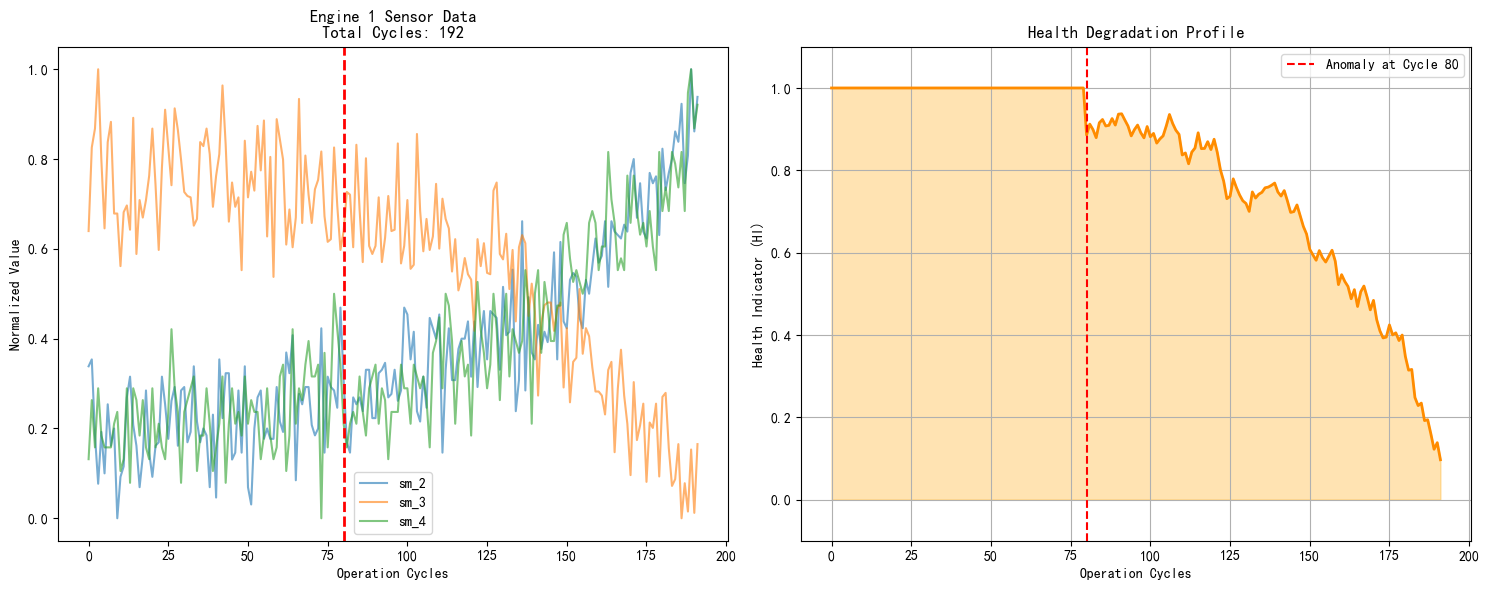

In [12]:
# 分析并可视化第一台发动机
engine_id = 0
HI, anomaly = generate_HI(engines[engine_id], column_names, **DETECT_PARAMS)  # 修正调用，添加 column_names 参数
print(f"发动机 {engine_id+1} 异常起始周期: {anomaly}")
# 可视化第一台发动机
visualize_results(engine_id, engines, column_names, DETECT_PARAMS)

In [18]:
# 调用保存函数
print("\nsaving HI")
save_all_hi_to_single_file(engines, column_names, DETECT_PARAMS, output_file="PWL_HI_train_FD001.csv")


saving HI
7/7 [==============================] - 0s 1ms/step
所有发动机HI数据已保存至：PWL_HI_train_FD001.csv
